__Regression of Air France Revenue:__

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorspacious import cspace_converter
from collections import OrderedDict
from matplotlib import cm
# Hierarchical CLustering of OECD Composite Indicator
# Import normalize
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pdb
mpl.rcParams['figure.figsize'] = 20, 5
mpl.rcParams['lines.linewidth'] = 2

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
df = pd.read_csv('fcfregress.csv', parse_dates=['Linear Forecast'], index_col='Linear Forecast')
# df = df[df.applymap(np.isreal).any(1)]
df = df.interpolate().ffill().bfill()
df = df.select_dtypes(include=['float64', 'int64'])
df= df.replace([np.inf, -np.inf], np.nan)
df = df_model = df
df.head()

,Free Cash Flow Forecast IFRS 16 + Forecasted crude oil,Free Cash Flow Forecast IFRS 17,Free Cash Flow Forecast IFRS 16,Free Cash Flow Forecast real capex,Free Cash Flow Forecast real NWC,"Free Cash Flow Forecast real capex, real NWC",Free Cash Flow (REAL) Total capital lease added in CL,Free Cash Flow (REAL) IFRS 17,Free Cash Flow (REAL) IFRS 16,Free Cash Flow (REAL) NWC > CA - CL bloomberg,...,SALES_REV_TURN.1,BS_OTHER_CUR_ASSET,OTHER_CURRENT_LIABS_DETAILED.1,ACCT_PAYABLE_&_ACCRUALS_DETAILED,BS_ACCT_NOTE_RCV,BS_INVENTORIES.1,NON_CASH_WORKING_CAPITAL,BS_ST_BORROW,BS_CASH_NEAR_CASH_ITEM,BS_CUR_LIAB.1
Linear Forecast,,,,,,,,,,,,,,,,,,,,,
Q1 2014,-313.479574,-197.390256,-313.479574,-160.134632,-197.390256,-174.283679,-256.128152,-256.128152,-189.128152,-290.600847,...,5429.136905,1117.125000,4650.875000,2293.541667,1945.904762,530.392857,-7518.601190,1812.660714,3118.339286,11857.17262
Q2 2014,-780.328518,-650.479347,-580.995184,-592.103679,-33.326014,-174.283679,-256.128152,-256.128152,-189.128152,196.871848,...,6309.303571,1134.791667,4351.375000,2407.541667,2002.571429,544.892857,-7422.767857,1681.827381,3359.339286,11823.17262
Q3 2014,940.238875,1316.904945,761.905542,1084.906171,2290.238278,2236.572837,1097.901105,1097.901105,2026.901105,1128.901105,...,6962.303571,1151.125000,4608.708333,2466.208333,1878.071429,541.392857,-6907.767857,1645.327381,3166.505952,11182.50595
Q4 2014,-1983.464841,-1891.115306,-1660.464841,-1494.630320,-1378.641973,-1305.156987,1445.144213,1445.144213,-672.855788,711.144212,...,6054.303571,972.625000,2563.708333,3122.708333,1705.404762,521.226191,-5872.434524,1843.327381,1841.339286,11178.00595
Q1 2015,1045.617297,1136.086921,803.860155,976.498493,773.836445,856.005160,-1473.329018,-1473.329018,799.670982,73.670982,...,5540.615476,1170.675000,4636.525000,2352.391667,2058.076190,559.435714,-7659.094048,1821.596429,3320.203571,12118.43690


                                                    labels
countries                                                 
Free Cash Flow Forecast IFRS 16 + Forecasted cr...      11
Free Cash Flow Forecast IFRS 17                         11
Free Cash Flow Forecast IFRS 16                         11
Free Cash Flow Forecast real capex                      11
Free Cash Flow Forecast real NWC                        11


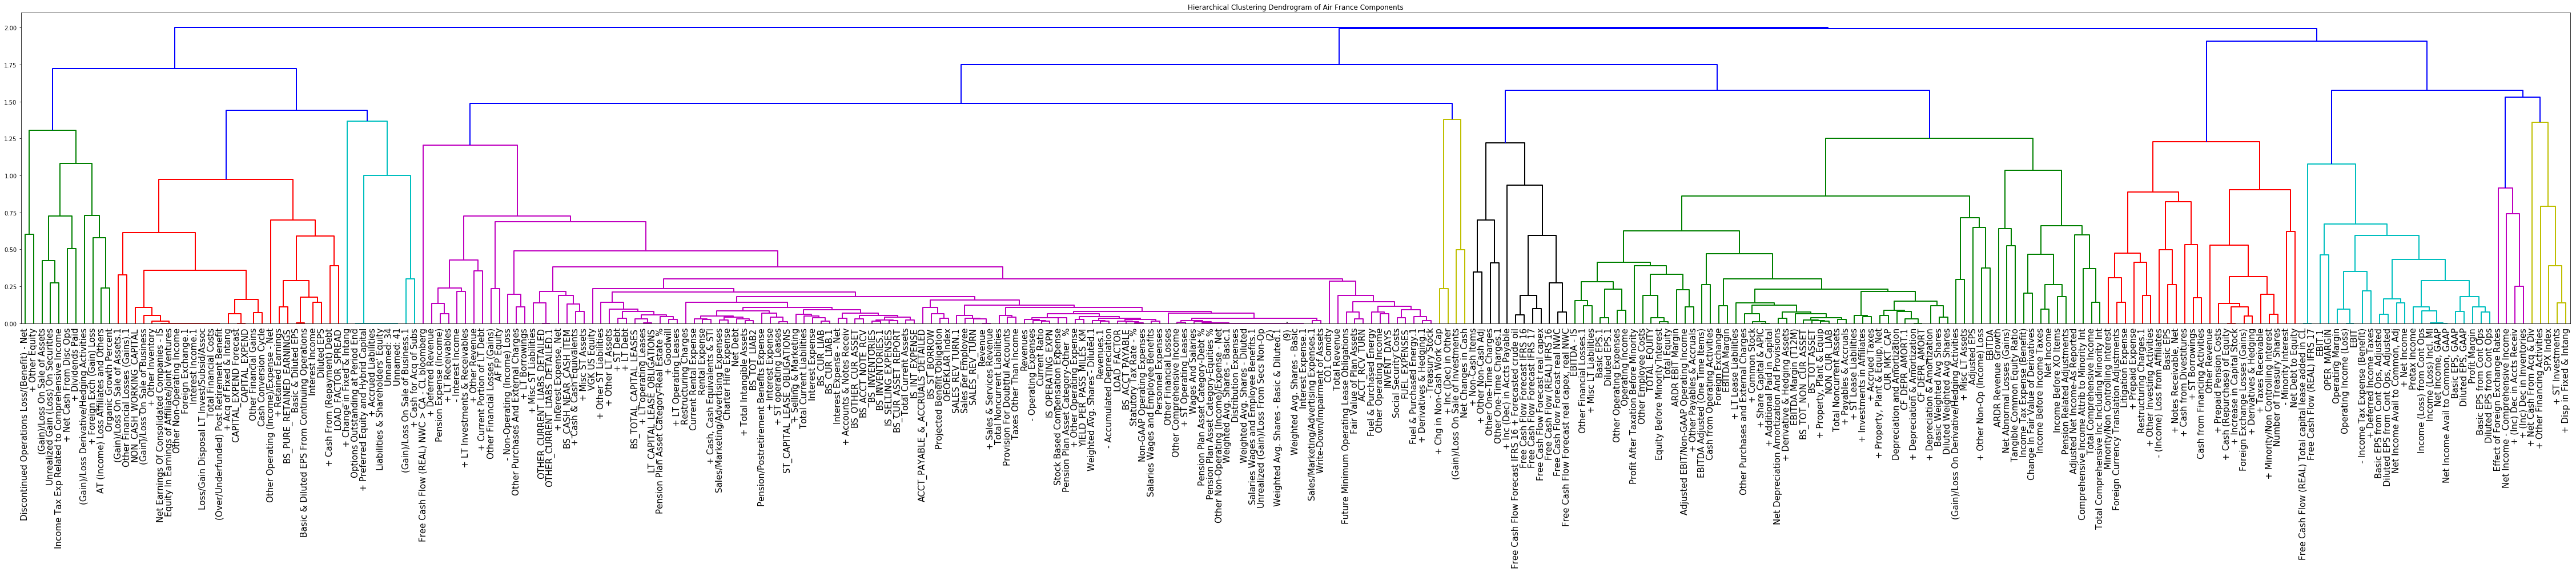

In [14]:
df_quadratic = df
dendrogram_data = df_quadratic.fillna(0).T

# Normalize the movements: normalized_movements
normalized_movements = normalize(dendrogram_data)

# Calculate the linkage: mergings
mergings = linkage(normalized_movements, method='complete')

labels = fcluster(mergings, 1.2, criterion='distance')
labels = pd.DataFrame({'labels':labels, 'countries':dendrogram_data.index}).set_index('countries')
print(labels.head())

# Plot the dendrogram
labelList = [i for i in dendrogram_data.index]

plt.figure(figsize=(80, 10))
plt.title('Hierarchical Clustering Dendrogram of Air France Components')
dendrogram(mergings,
           truncate_mode='level',
           leaf_rotation=90.,
           leaf_font_size=15.,
           labels=labelList,
           show_contracted=True)
plt.show();

In [29]:
y_names = ['FUEL_EXPENSES']

# df_model = df_model.drop(columns='Adj Close')
features_names_model = df_model.columns.drop(y_names).tolist()      

feature_target_df = df_model[y_names + features_names_model].diff(1).dropna()

# Modification of features/target data properties (diff, shift, lag, etc..).
targets_original = feature_target_df[y_names]
features_original = feature_target_df[features_names_model].fillna(0)

In [30]:
def buildLaggedFeatures(s,lag=2,dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print ('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res
lag = 4
features_lagged = buildLaggedFeatures(features_original, lag=lag, dropna=True)

In [31]:
targets = targets_original[(lag):]
features = features_lagged

In [32]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.70 * features.shape[0])
train_features = X = linear_features[:train_size]
train_targets  = Y = targets[:train_size]
test_features  = x = linear_features[train_size:]
test_targets   = y = targets[train_size:]

print('train_size:', train_size, 'full_df:',linear_features.shape, 'X:', train_features.shape, 'x:', test_features.shape, 'y:', test_targets.shape)

train_size: 44 full_df: (64, 1796) X: (44, 1796) x: (20, 1796) y: (20, 1)


c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


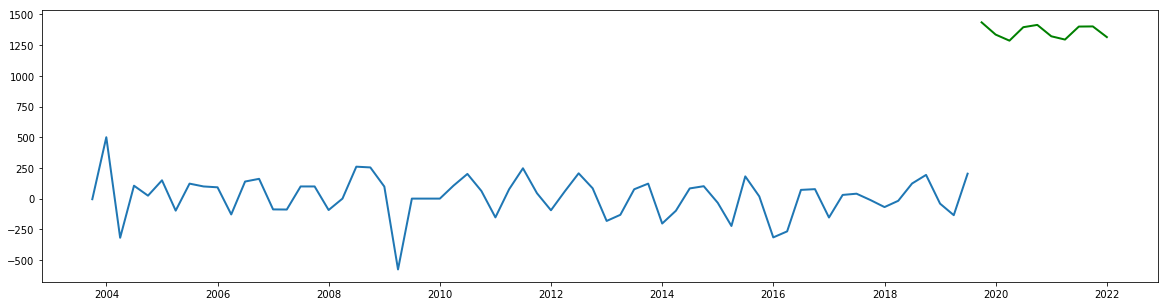

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create ARIMA(2,1,2) model
arima = SARIMAX(df_model[y_names], order=(4,1,4))

# Fit ARIMA model
arima_results = arima.fit()
    
# Make ARIMA forecast of next 10 values
arima_value_forecast_yohat = arima_results.get_forecast(steps=10).predicted_mean

plt.plot(arima_value_forecast_yohat, 'g', targets)

In [34]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(X, Y))
print(rfr.score(x, y))

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.8976351058355941
0.5731950909821164


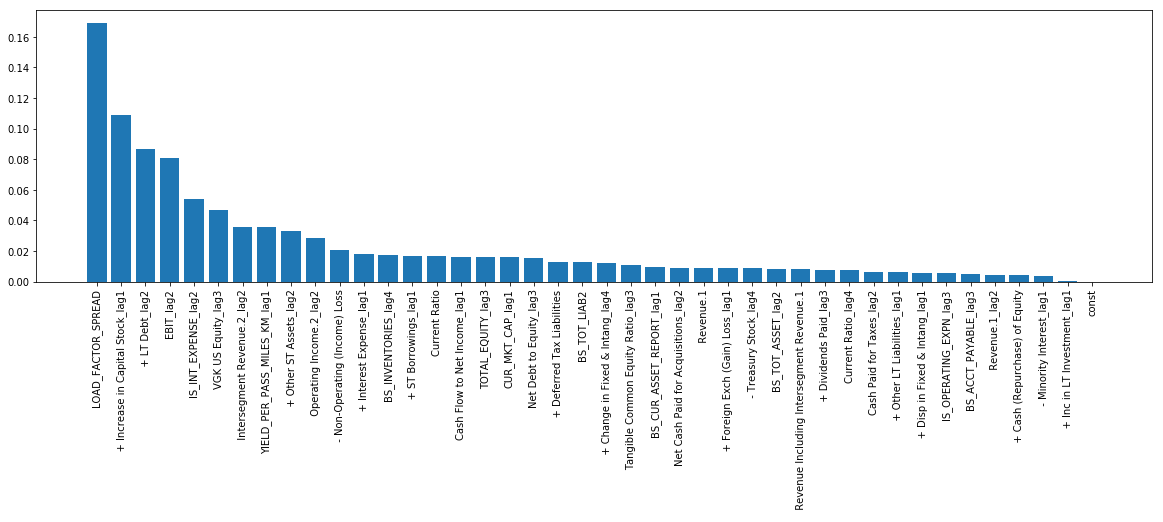

In [50]:
# Exrtract features importance with built-in function of random forest regressor
features_importances = rfr.feature_importances_

# Sort the index that will be our reference for the positino of each index regarding there importances
sorted_index = np.argsort(features_importances)[::-1][:100]

# Create the corresponding labels to importances position
features_count = range(len(sorted_index))
labels = np.array(linear_features.columns.to_list())[sorted_index][:100]

def map_importance(model):   
    # Plot the graph
    plt.bar(features_count, features_importances[sorted_index], tick_label=labels)
    plt.xticks(rotation=90)
    plt.show()

mpl.rcParams['figure.figsize'] = 20 , 5
map_importance(rfr)

In [27]:
# features_VIF = features[labels]

# from statsmodels.stats.outliers_influence import variance_inflation_factor    

# def calculate_vif_(X, thresh=5.0):
#     variables = list(range(X.shape[1]))
#     dropped = True
#     while dropped:
#         dropped = False
#         vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
#                for ix in range(X.iloc[:, variables].shape[1])]

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
#                   '\' at index: ' + str(maxloc))
#             del variables[maxloc]
#             dropped = True

#     print('Remaining variables:')
#     print(X.columns[variables])
#     return X.iloc[:, variables]


# features_VIF_mask = calculate_vif_(features_VIF)

In [37]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features_VIF_mask)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.80 * features.shape[0])
train_features = X = linear_features[:train_size]
train_targets  = Y = targets[:train_size]
test_features  = x = linear_features[train_size:]
test_targets   = y = targets[train_size:]

print('train_size:', train_size, 'full_df:',linear_features.shape, 
      'X:', train_features.shape, 'x:', test_features.shape, 
      'y:', test_targets.shape)

train_size: 51 full_df: (64, 42) X: (51, 42) x: (13, 42) y: (13, 1)


In [38]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
results = rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(X, Y))
print(rfr.score(x, y))

0.9050089705160534
0.44849875483969476


c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


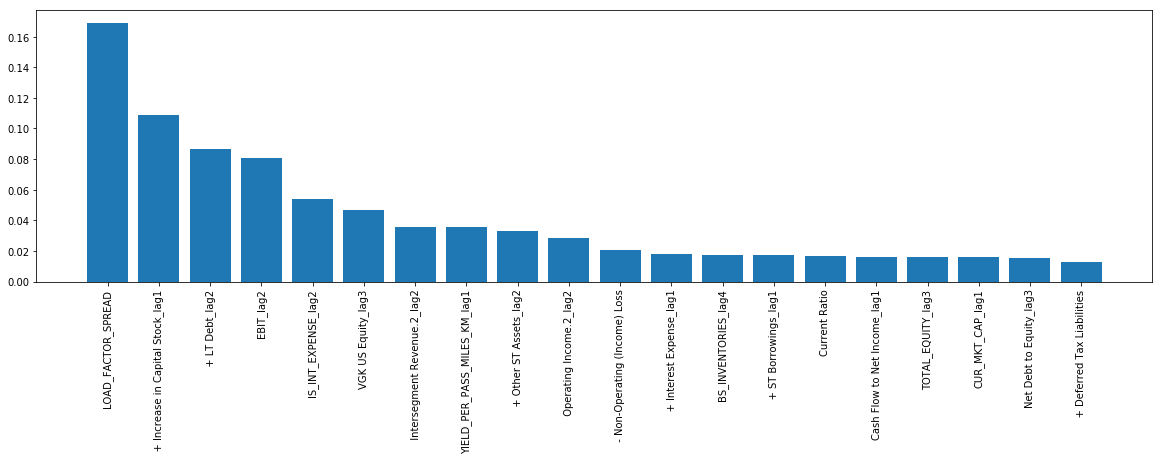

In [39]:
# Exrtract features importance with built-in function of random forest regressor
features_importances = rfr.feature_importances_

# Sort the index that will be our reference for the positino of each index regarding there importances
sorted_index = np.argsort(features_importances)[::-1][:20]

# Create the corresponding labels to importances position
features_count = range(len(sorted_index))
labels = np.array(linear_features.columns.to_list())[sorted_index][:20]

def map_importance(model):   
    # Plot the graph
    plt.bar(features_count, features_importances[sorted_index], tick_label=labels)
    plt.xticks(rotation=90)
    plt.show()

mpl.rcParams['figure.figsize'] = 20 , 5
map_importance(rfr)


In [40]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, Y):
    # Perform Grid-Search
    gsc = GridSearchCV(
       estimator=RandomForestRegressor(),
       param_grid={
           'max_depth': range(2,5),
           'n_estimators': (50, 75, 100, 150)},
       cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)
    best_params = grid_result.best_params_

    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_absolute_error')

    return scores

rfr_model(X,Y)

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\lucas\appdata\local\program

array([-173.53728406,  -93.31825612,  -48.4676691 , -119.37175537,
       -200.38298698,  -54.06154942, -111.94740508,  -82.85305952,
        -66.20130915, -180.03114947])

In [41]:
scores = cross_val_score(rfr, x, y.values.ravel(), cv=10, scoring='neg_mean_absolute_error')
predictions = cross_val_predict(rfr, x, y.values.ravel(), cv=10)

In [42]:
train_predictions = Yhat = pd.Series(results.predict(X))
test_predictions = yhat = pd.Series(results.predict(x))
print(type(test_predictions))

<class 'pandas.core.series.Series'>


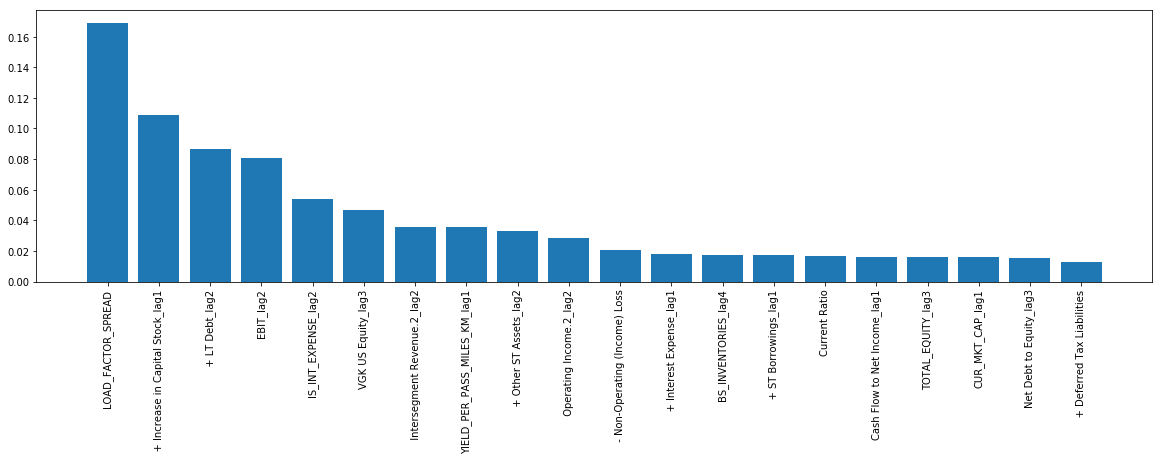

Mean Y:  FUEL_EXPENSES    15.0
dtype: float64
Mean predictions:  16.519

Score of model in sample: 0.905
Score of model out-of-sample: 0.448

R² in sample:  0.224
R² Out-of-sample:  0.282


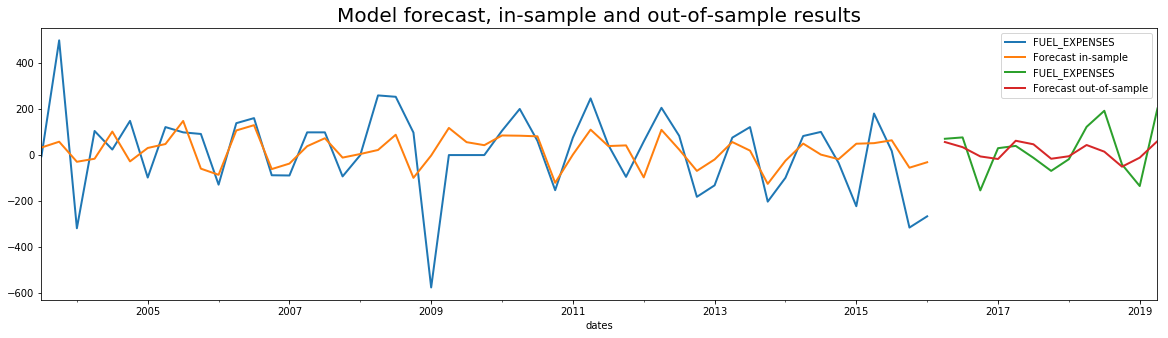

In [43]:
def plot_test_train_results(model, Y, y, Yhat, yhat):
    Y_hat = pd.DataFrame(cross_val_predict(model, X, Y.values.ravel(), cv=10))
    y_hat = pd.DataFrame(cross_val_predict(model, x, y.values.ravel(), cv=10))
    Y_and_y = (Y.values.tolist()).append(y.values.tolist())
#     Yhat_and_yhat = (Yhat.values.tolist()).append(yhat.values.tolist())
    
    #Print results & comments
    print('Mean Y: ', np.mean(Y).round(3))
    print('Mean predictions: ', np.mean(Yhat).round(3))
    print()
    print('Score of model in sample:', model.score(X, Y).round(3))
    print('Score of model out-of-sample:',model.score(x, y).round(3))
    print()
    print("R² in sample: ", r2_score(Y, Y_hat).round(3))
    print("R² Out-of-sample: ", r2_score(y, y_hat).round(3))
    
    Yhat = Y.join(Y_hat.set_index(Y.index))
    Yhat.columns = [y_names[0], 'Forecast in-sample']
    yhat = y.join(y_hat.set_index(y.index))
    yhat.columns = [y_names[0], 'Forecast out-of-sample']
    
    
    ax = Yhat.plot()
    yhat.plot(ax=ax)
    labels = [y_names, 'Forecast -In-sample', y_names, 'Forecast -Out-of-sample', 'predictions using Random Forest model']
    plt.title('Model forecast, in-sample and out-of-sample results', fontsize=20)

map_importance(rfr)
plot_test_train_results(rfr, Y, y, Yhat, yhat)

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Y:  FUEL_EXPENSES    15.0
dtype: float64
Mean predictions:  16.519

Score of model in sample: 0.953
Score of model out-of-sample: 0.337

R² in sample:  0.226
R² Out-of-sample:  0.206


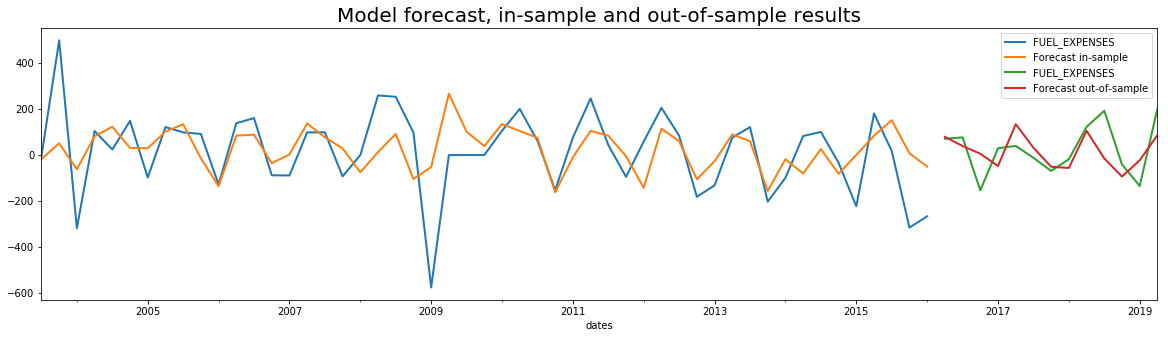

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gsc = GridSearchCV(
   estimator=GradientBoostingRegressor(),
   param_grid={
       'max_depth': range(2,5),
       'n_estimators': (50, 70, 150, 200, 400),
       'learning_rate': (0.05, 0.03, 0.02, 0.01, 0.005),
#        'subsample': (0.3, 0.5,0.6, 0.7),
#        'min_samples_split': (2, 4),#
       'random_state': (42, 60, 80)},#,#
#        'loss': ('ls', 'huber', 'quantile', 'lad')},
   cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_

gbr = GradientBoostingRegressor(max_depth        = best_params["max_depth"],
                               n_estimators      = best_params["n_estimators"],
                               learning_rate     = best_params["learning_rate"],
#                                subsample         = best_params["subsample"],
#                                min_samples_split = best_params["min_samples_split"],
#                                random_state      = best_params["random_state"],
#                                loss              = best_params["loss"],
                               verbose=False)

scores = cross_val_score(gbr, x, y.values.ravel(), cv=5, scoring='neg_mean_absolute_error')

# Perform K-Fold CV
gbr.fit(X,Y)
plot_test_train_results(gbr, Y, y, Yhat, yhat)

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


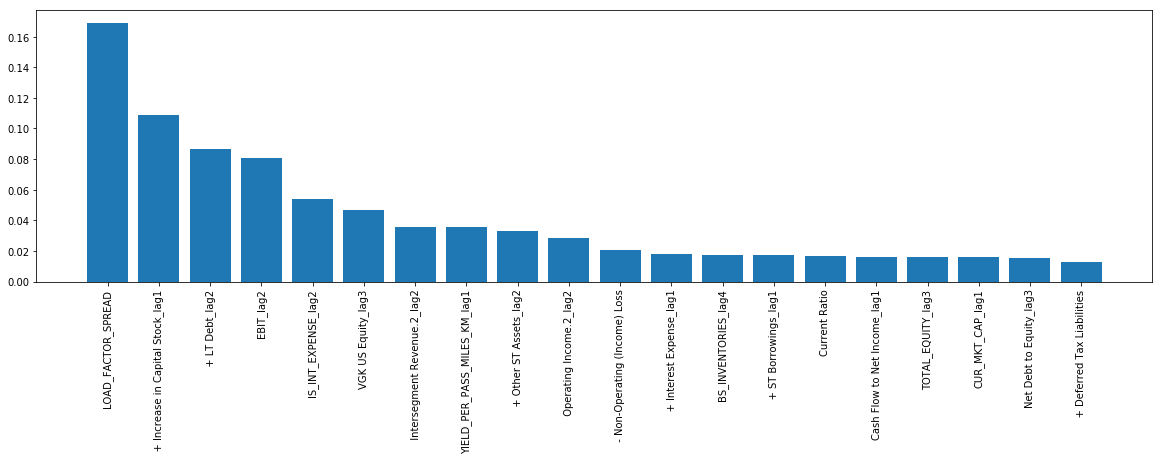

Mean Y:  FUEL_EXPENSES    15.0
dtype: float64
Mean predictions:  16.519

Score of model in sample: 0.897
Score of model out-of-sample: 0.318

R² in sample:  0.257
R² Out-of-sample:  -0.184


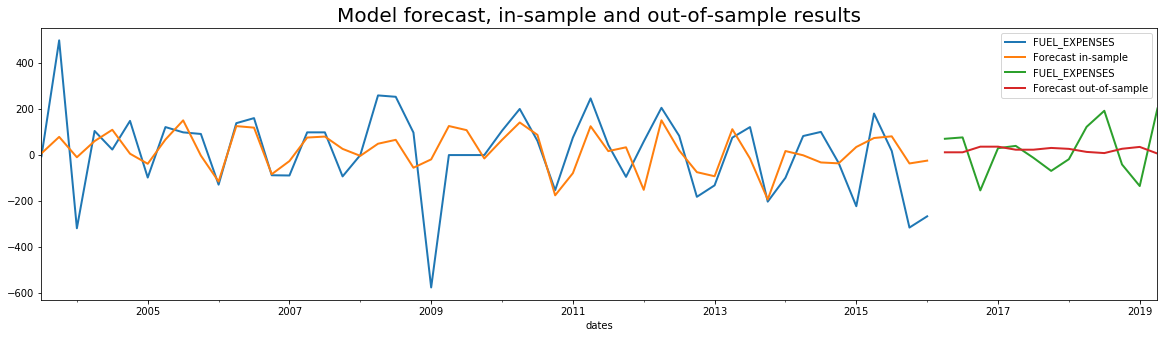

In [45]:
gbr = GradientBoostingRegressor(
    loss='ls',
    learning_rate=0.01,
    n_estimators=400,
    subsample=0.6,
    criterion='friedman_mse',
    min_samples_split=5,
    min_samples_leaf=4,
    min_weight_fraction_leaf=0.,
    max_depth=3,
    min_impurity_decrease=0.1,
    min_impurity_split=None,
    init=None,
    random_state=60,
    max_features=10,
    alpha=0.8,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='auto',
    validation_fraction=0.01,
    n_iter_no_change=None,
    tol=0.001)

gbr.fit(X,Y)
map_importance(gbr)
plot_test_train_results(gbr, Y, y, Yhat, yhat)

In [ ]:
mpl.rcParams['figure.figsize'] = 20, 5
mpl.rcParams['lines.linewidth'] = 2
df = pd.read_excel('fpregress.xlsx', parse_dates=['Dates'], index_col='Dates')
data = df_model = df.fillna(method='ffill').fillna(method='bfill').dropna(axis=1)
data.head(40).pct_change().iloc[[0,2,-2,-1],:]

In [ ]:
df_model.plot()

In [ ]:
y_names = ['EBITDA']

# df_model = df_model.drop(columns='Adj Close')
features_names_model = df_model.columns.drop(y_names).tolist()      

feature_target_df = df_model[y_names + features_names_model].pct_change().dropna()

In [ ]:
# Modification of features/target data properties (diff, shift, lag, etc..).
targets = feature_target_df[y_names]
features = feature_target_df[features_names_model]
features.iloc[[0,1,-2,-1],:]

__Test-Train split__

In [ ]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.80 * features.shape[0])
train_features = X = linear_features[:train_size]
train_targets  = Y = targets[:train_size]
test_features  = x = linear_features[train_size:]
test_targets   = y = targets[train_size:]

print(linear_features.shape, train_features.shape, test_features.shape)

__Regression using Random Forest Regressor__

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(X, Y))
print(rfr.score(x, y))

0.7414372606639121
-44.890509473111344


c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Now with classic Random Forest Regressor we can extract features importances

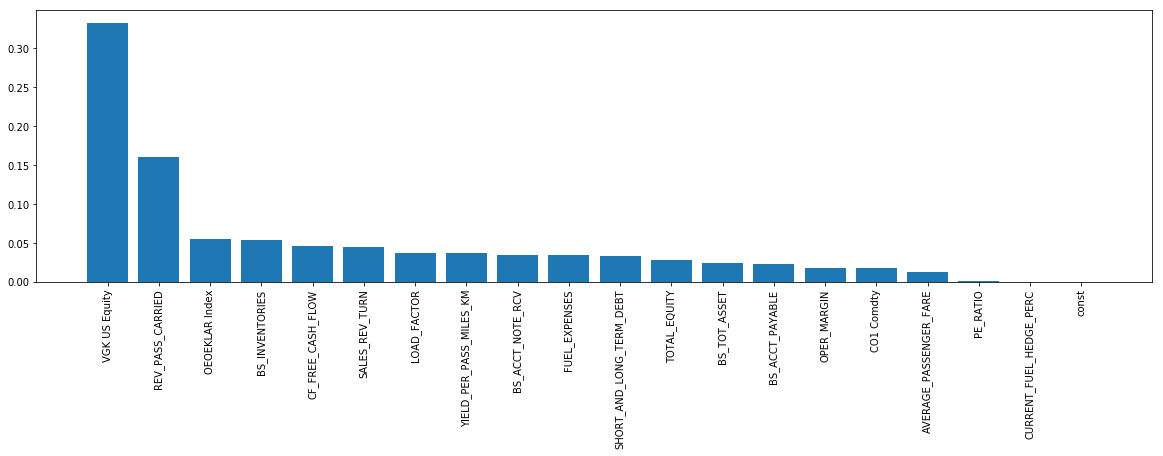

In [8]:
def map_importance(model):

    # Exrtract features importance with built-in function of random forest regressor
    features_importances = model.feature_importances_

    # Sort the index that will be our reference for the positino of each index regarding there importances
    sorted_index = np.argsort(features_importances)[::-1]

    # Create the corresponding labels to importances position
    features_count = range(len(features_importances))
    labels = np.array(linear_features.columns.to_list())[sorted_index]

    # Plot the graph
    plt.bar(features_count, features_importances[sorted_index], tick_label=labels)
    plt.xticks(rotation=90)
    plt.show()

map_importance(rfr)

__Randomized Hyper Paramters Tuning__

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, features_names_model)

ValueError: Found input variables with inconsistent numbers of samples: [56, 19]

__Let's play with parameter tuning using gridsearch cross validation__

In [46]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, Y):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(2,5),
            'n_estimators': (10, 50, 100, 200, 400, 600)},
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, Y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, Y, cv=10, scoring='neg_mean_absolute_error')

    return scores

rfr_model(X,Y)

c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
c:\users\lucas\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\lucas\appdata\local\program

array([-184.7611807 ,  -83.73778919,  -48.81639657, -112.22371586,
       -201.29466092,  -49.14032427, -104.81506127,  -77.35574959,
        -60.98661375, -185.87158347])

In [47]:
scores = cross_val_score(rfr, x, y.values.ravel(), cv=10, scoring='neg_mean_absolute_error')

In [48]:
predictions = cross_val_predict(rfr, x, y.values.ravel(), cv=10)

Mean Y:  23.6923
Mean predictions:  11.3354
Score of model in sample: 0.905
Score of model out-of-sample: 0.4485


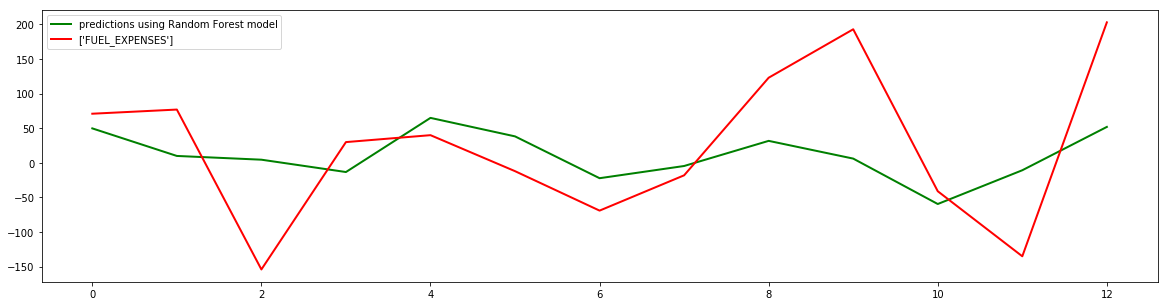

In [49]:
def vizualize_model(model, test_targets):
    predictions = cross_val_predict(model, x, y.values.ravel(), cv=10)
    scores = cross_val_score(model, x, y.values.ravel(), cv=10, scoring='neg_mean_absolute_error')
    y_variables = y.values.tolist()
    
    plt.plot(predictions, 'g', y_variables, 'r')
    labels = ['predictions using Random Forest model', y_names]
    plt.legend(labels)
    
    #Print results & comments
    print('Mean Y: ', np.mean(y_variables).round(4))
    print('Mean predictions: ', np.mean(predictions).round(4))
    print('Score of model in sample:', model.score(X, Y).round(4))
    print('Score of model out-of-sample:',model.score(x, y).round(4))

vizualize_model(rfr, y)

__Gradient Boosting Regressor:__

https://campus.datacamp.com/courses/machine-learning-for-finance-in-python/machine-learning-tree-methods?ex=13

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gsc = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid={
        'max_depth': range(2,4),
        'n_estimators': (200, 400, 600),#, 200, 400, 600),
        'learning_rate': (0.2, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005),
        'subsample': (0.3, 0.4, 0.5,0.6, 0.7),
        'min_samples_split': (5, 4, 3, 2),
        'random_state': (80, 70, 60, 50, 40),
        'loss': ('ls', 'huber', 'quantile', 'lad')},
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_

gbr = GradientBoostingRegressor(max_depth         = best_params["max_depth"],
                                n_estimators      = best_params["n_estimators"],
                                learning_rate     = best_params["learning_rate"],
                                subsample         = best_params["subsample"],
                                min_samples_split = best_params["min_samples_split"],
                                random_state      = best_params["random_state"],
                                loss              = best_params["loss"],
                                verbose=False)

scores = cross_val_score(gbr, X, y, cv=10, scoring='neg_mean_absolute_error')

# Perform K-Fold CV
gbr.fit(X,Y)

print(gbr.score(X, Y))
print(gbr.score(x, y))

KeyboardInterrupt: 

In [ ]:
grid_result.cv_results_

In [ ]:
gbr = GradientBoostingRegressor(
    loss='ls',
    learning_rate=0.01,
    n_estimators=400,
    subsample=0.6,
    criterion='friedman_mse',
    min_samples_split=5,
    min_samples_leaf=4,
    min_weight_fraction_leaf=0.,
    max_depth=3,
    min_impurity_decrease=0.1,
    min_impurity_split=None,
    init=None,
    random_state=60,
    max_features=20,
    alpha=0.8,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='auto',
    validation_fraction=0.01,
    n_iter_no_change=None,
    tol=0.001)

gbr.fit(X,Y)
print(gbr.score(X, Y))
print(gbr.score(x, y))

In [ ]:
map_importance(gbr)

Mean Y:  -0.0046
Mean predictions:  -0.0086


NotFittedError: This GradientBoostingRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

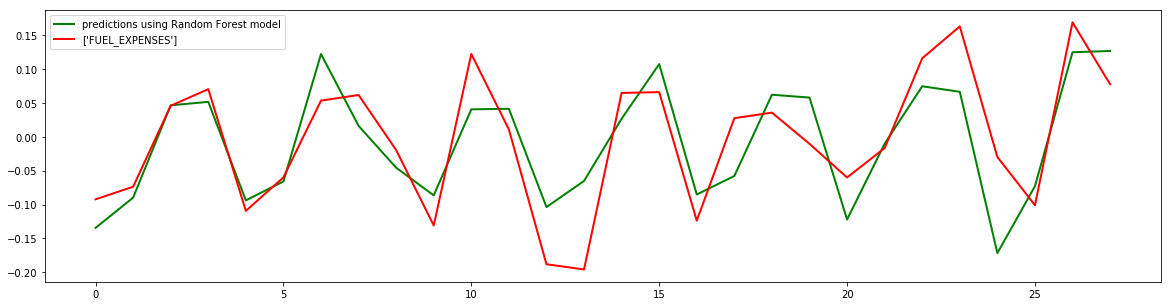

In [634]:
vizualize_model(gbr, y)

In [279]:
# Create the linear model and complete the least squares fit

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0


# Make predictions from our model for train and test sets
train_predictions = Yhat = results.predict(X)
test_predictions = yhat = results.predict(x)

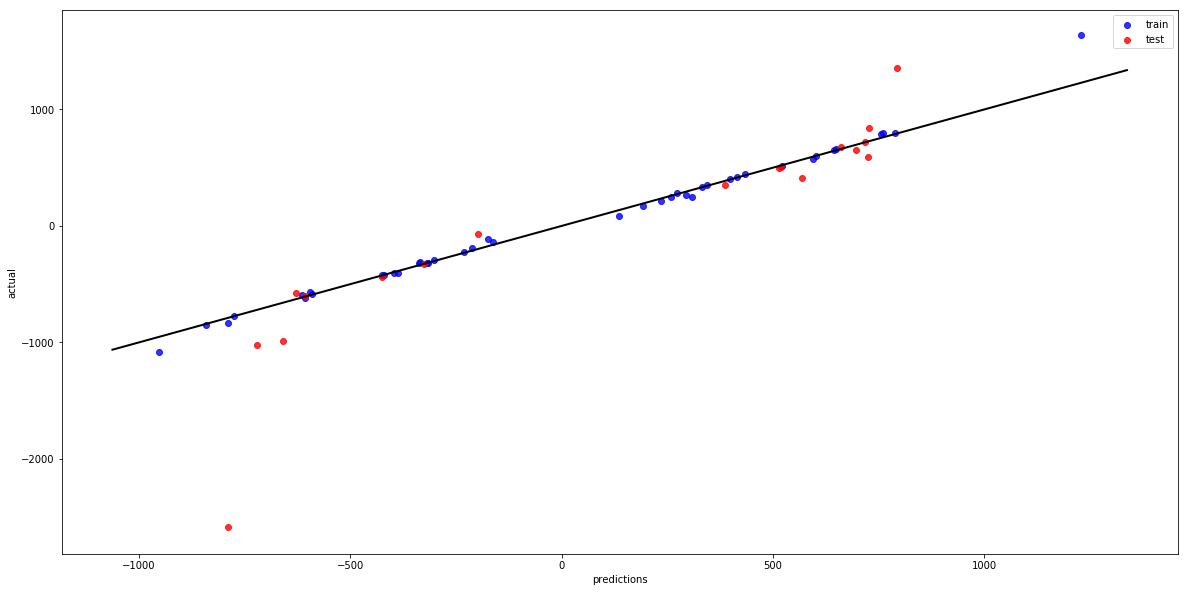

In [280]:
# Scatter the predictions vs the targets with 80% transparency
plt.figure(figsize=(20,10))
plt.scatter(Yhat, Y, alpha=0.8, color='b', label='train')
plt.scatter(yhat, y, alpha=0.8, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), color='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

In [283]:
Yhat = pd.DataFrame(Yhat)
yhat = pd.DataFrame(yhat)

TypeError: index type not supported

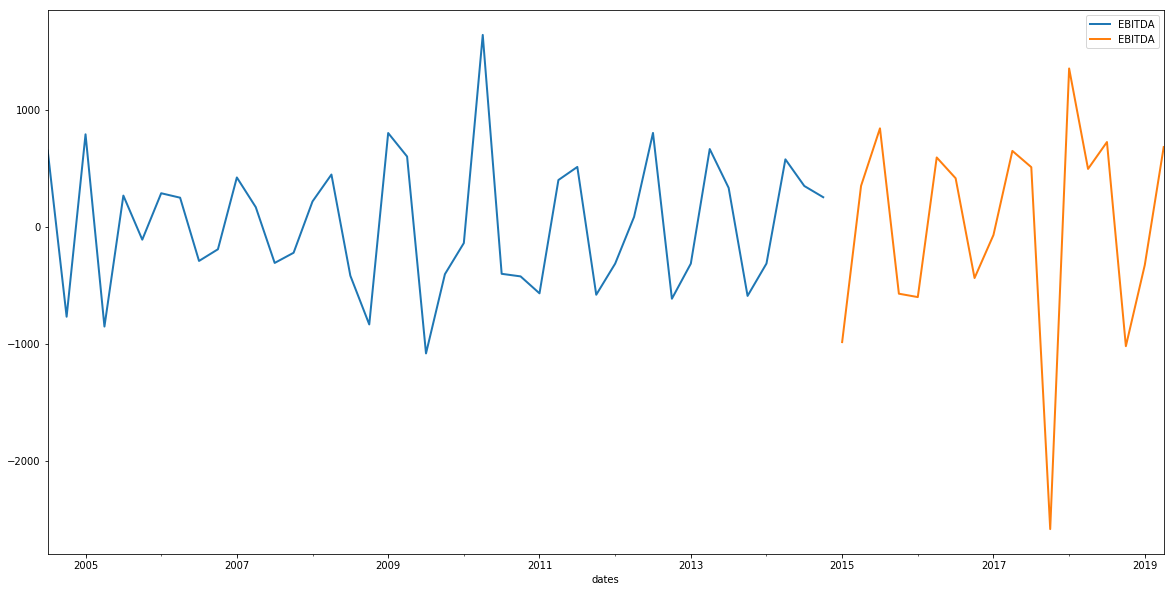

In [284]:
def plot_test_train_results(Y, y, Yhat, yhat):
    ax = Y.plot(figsize=(20,10))
    y.plot(ax=ax)
    Yhat.plot(ax=ax, label='Yhat', legend='Yhat')
    yhat.plot(ax=ax, label='yhat', legend='yhat')
    plt.title('Model forecast, in-sample and out-of-sample results')
    
plot_test_train_results(Y, y, Yhat, yhat)